In [1]:
import pickle
import sys
from zoneinfo import ZoneInfo
sys.path.append("../")

from dotenv import load_dotenv
load_dotenv()
import geopandas as gpd
import importlib
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import lightning.pytorch as pl
import rasterio as rio
from rasterio.plot import show
import seaborn as sns
import shapely
import statsmodels.api as sm
from torch.utils.data import DataLoader

from openbustools import plotting, spatial, standardfeeds
from openbustools.traveltime import data_loader, model_utils
from openbustools.drivecycle import trajectory
from openbustools.drivecycle.physics import conditions, energy, vehicle

### Phone Baseline Compared to Realtime

In [ ]:
importlib.reload(trajectory)
importlib.reload(energy)
importlib.reload(standardfeeds)
importlib.reload(vehicle)
importlib.reload(spatial)

all_phone_intensities = []
all_realtime_intensities = []

# List of phone trajectories available that have matching realtime data
phone_trajectory_folders = [x for x in Path("..","data","kcm_sensor","match_realtime").glob("*") if x.is_dir()]

# Build trajectory for each phone recording
for phone_trajectory_folder in phone_trajectory_folders:
    # Load phone data
    metadata_phone, data_phone = standardfeeds.combine_phone_sensors(phone_trajectory_folder, "America/Los_Angeles")
    data_phone.loc[data_phone['speed']<0, 'speed'] = np.nan
    data_phone.loc[data_phone['bearing']<0, 'bearing'] = np.nan
    data_phone = data_phone.bfill()
    # Create trajectory
    phone_traj = trajectory.Trajectory(
        point_attr={
            "lon": data_phone.longitude.to_numpy(),
            "lat": data_phone.latitude.to_numpy(),
            "measured_elev_m": data_phone.altitudeAboveMeanSeaLevel.to_numpy(),
            "measured_speed_m_s": data_phone.speed.to_numpy(),
            "measured_bear_d": data_phone.bearing.to_numpy(),
            "measured_accel_m_s2": np.diff(data_phone.speed.to_numpy(), prepend=0), # Can be accelerometer or speed derivative
            "measured_theta_d": data_phone.pitch.to_numpy() - np.mean(data_phone.pitch.to_numpy()),
            "cumul_time_s": data_phone.cumul_time_s.to_numpy(),
        },
        traj_attr=metadata_phone,
        coord_ref_center=[386910, 69022],
        epsg=32148,
        apply_filter=True
    )
    # Create drivecycle
    phone_cycle = phone_traj.to_momentary_drivecycle()
    energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
    phone_cycle_energy_df = energy_model.getEnergyDataFrame(phone_cycle)
    all_phone_intensities.append(energy_model.calcIntensity(phone_cycle)*1.6)


    # Load corresponding realtime data
    data_realtime = pd.read_pickle(Path("..", "data", "kcm_sensor_realtime", f"{phone_traj.traj_attr['t_day']}.pkl"))
    # Pull the phone trajectory
    data_realtime = data_realtime[data_realtime['vehicleid'].astype(int).astype(str) == phone_traj.traj_attr['veh_id']]
    data_realtime = data_realtime[data_realtime['locationtime'].astype(int) >= phone_traj.traj_attr['start_epoch']]
    data_realtime = data_realtime[data_realtime['locationtime'].astype(int) <= phone_traj.traj_attr['end_epoch']]
    # Create trajectory
    realtime_traj = trajectory.Trajectory(
        point_attr={
            "lon": data_realtime.lon.to_numpy(),
            "lat": data_realtime.lat.to_numpy(),
            "cumul_time_s": (data_realtime.locationtime - data_realtime.locationtime.min()).to_numpy(),
        },
        traj_attr=metadata_phone,
        coord_ref_center=[386910, 69022],
        epsg=32148,
        dem_file=Path("..", "data", "kcm_spatial","usgs10m_dem_32148.tif"),
        apply_filter=False
    )
    # Create drivecycle
    realtime_cycle = realtime_traj.to_averaged_drivecycle()
    energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
    realtime_cycle_energy_df = energy_model.getEnergyDataFrame(realtime_cycle)
    all_realtime_intensities.append(energy_model.calcIntensity(realtime_cycle)*1.6)

In [ ]:
print("Phone")
energy_model.printSummary(phone_cycle)
print(f"Mean: {np.mean(all_phone_intensities):.2f} kWh/mi")
print()
print("Realtime") 
energy_model.printSummary(realtime_cycle)
print(f"Mean: {np.mean(all_realtime_intensities):.2f} kWh/mi")
print()
print(f"RMSE: {np.sqrt(np.mean((np.array(all_phone_intensities) - np.array(all_realtime_intensities))**2)):.2f} (kWh/mi)")

In [ ]:
realtime_cycle_energy_df['source'] = 'realtime'
realtime_cycle_energy_df['cumul_time_s'] = realtime_cycle_energy_df['Time'].cumsum()
phone_cycle_energy_df['source'] = 'phone'
phone_cycle_energy_df['cumul_time_s'] = phone_cycle_energy_df['Time'].cumsum()
rt_df = realtime_cycle_energy_df[['source','cumul_time_s','Velocity','Acceleration','Theta','Time','Distance','P_tot']]
ph_df = phone_cycle_energy_df[['source','cumul_time_s','Velocity','Acceleration','Theta','Time','Distance','P_tot']]
plot_df = pd.concat([rt_df, ph_df], axis=0)
plotting.formatted_trajectory_lineplot(plot_df)

### Phone Baseline Compared to Realtime Resampled

In [ ]:
importlib.reload(trajectory)
importlib.reload(energy)
importlib.reload(standardfeeds)
importlib.reload(vehicle)
importlib.reload(spatial)

all_phone_intensities = []
all_realtime_intensities = []

# List of phone trajectories available that have matching realtime data
phone_trajectory_folders = [x for x in Path("..","data","kcm_sensor","match_realtime").glob("*") if x.is_dir()]

# Build trajectory for each phone recording
for phone_trajectory_folder in phone_trajectory_folders:
    # Load phone data
    metadata_phone, data_phone = standardfeeds.combine_phone_sensors(phone_trajectory_folder, "America/Los_Angeles")
    data_phone.loc[data_phone['speed']<0, 'speed'] = np.nan
    data_phone.loc[data_phone['bearing']<0, 'bearing'] = np.nan
    data_phone = data_phone.bfill()
    # Create trajectory
    phone_traj = trajectory.Trajectory(
        point_attr={
            "lon": data_phone.longitude.to_numpy(),
            "lat": data_phone.latitude.to_numpy(),
            "measured_elev_m": data_phone.altitudeAboveMeanSeaLevel.to_numpy(),
            "measured_speed_m_s": data_phone.speed.to_numpy(),
            "measured_bear_d": data_phone.bearing.to_numpy(),
            "measured_accel_m_s2": np.diff(data_phone.speed.to_numpy(), prepend=0), # Can be accelerometer or speed derivative
            "measured_theta_d": data_phone.pitch.to_numpy() - np.mean(data_phone.pitch.to_numpy()),
            "cumul_time_s": data_phone.cumul_time_s.to_numpy(),
        },
        traj_attr=metadata_phone,
        coord_ref_center=[386910, 69022],
        epsg=32148,
        apply_filter=True
    )
    # Create drivecycle
    phone_cycle = phone_traj.to_momentary_drivecycle()
    energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
    phone_cycle_energy_df = energy_model.getEnergyDataFrame(phone_cycle)
    all_phone_intensities.append(energy_model.calcIntensity(phone_cycle)*1.6)


    # Load corresponding realtime data
    data_realtime = pd.read_pickle(Path("..", "data", "kcm_sensor_realtime", f"{phone_traj.traj_attr['t_day']}.pkl"))
    # Pull the phone trajectory
    data_realtime = data_realtime[data_realtime['vehicleid'].astype(int).astype(str) == phone_traj.traj_attr['veh_id']]
    data_realtime = data_realtime[data_realtime['locationtime'].astype(int) >= phone_traj.traj_attr['start_epoch']]
    data_realtime = data_realtime[data_realtime['locationtime'].astype(int) <= phone_traj.traj_attr['end_epoch']]
    # Create trajectory
    realtime_traj = trajectory.Trajectory(
        point_attr={
            "lon": data_realtime.lon.to_numpy(),
            "lat": data_realtime.lat.to_numpy(),
            "cumul_time_s": (data_realtime.locationtime - data_realtime.locationtime.min()).to_numpy(),
        },
        traj_attr=metadata_phone,
        coord_ref_center=[386910, 69022],
        epsg=32148,
        dem_file=Path("..", "data", "kcm_spatial","usgs10m_dem_32148.tif"),
        apply_filter=False,
        resample_len=phone_traj.traj_len
    )
    # Create drivecycle
    realtime_cycle = realtime_traj.to_averaged_drivecycle()
    energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
    realtime_cycle_energy_df = energy_model.getEnergyDataFrame(realtime_cycle)
    all_realtime_intensities.append(energy_model.calcIntensity(realtime_cycle)*1.6)

In [ ]:
print("Phone")
energy_model.printSummary(phone_cycle)
print(f"Mean: {np.mean(all_phone_intensities):.2f} kWh/mi")
print()
print("Realtime") 
energy_model.printSummary(realtime_cycle)
print(f"Mean: {np.mean(all_realtime_intensities):.2f} kWh/mi")
print()
print(f"RMSE: {np.sqrt(np.mean((np.array(all_phone_intensities) - np.array(all_realtime_intensities))**2)):.2f} (kWh/mi)")

In [ ]:
realtime_cycle_energy_df['source'] = 'realtime'
realtime_cycle_energy_df['cumul_time_s'] = realtime_cycle_energy_df['Time'].cumsum()
phone_cycle_energy_df['source'] = 'phone'
phone_cycle_energy_df['cumul_time_s'] = phone_cycle_energy_df['Time'].cumsum()
rt_df = realtime_cycle_energy_df[['source','cumul_time_s','Velocity','Acceleration','Theta','Time','Distance','P_tot']]
ph_df = phone_cycle_energy_df[['source','cumul_time_s','Velocity','Acceleration','Theta','Time','Distance','P_tot']]
plot_df = pd.concat([rt_df, ph_df], axis=0)
plotting.formatted_trajectory_lineplot(plot_df)

### Phone Baseline Compared to Resampled + Modeled

In [14]:
importlib.reload(trajectory)
importlib.reload(energy)
importlib.reload(standardfeeds)
importlib.reload(vehicle)
importlib.reload(spatial)
importlib.reload(pl)


logging.getLogger("pytorch_lightning").setLevel(logging.CRITICAL)
all_phone_intensities = []
all_realtime_intensities = []

# List of phone trajectories available that have matching realtime data
phone_trajectory_folders = [x for x in Path("..","data","kcm_sensor","match_realtime").glob("*") if x.is_dir()]

# Build trajectory for each phone recording
for phone_trajectory_folder in phone_trajectory_folders:
    # Load phone data
    metadata_phone, data_phone = standardfeeds.combine_phone_sensors(phone_trajectory_folder, "America/Los_Angeles")
    data_phone.loc[data_phone['speed']<0, 'speed'] = np.nan
    data_phone.loc[data_phone['bearing']<0, 'bearing'] = np.nan
    data_phone = data_phone.bfill()
    # Create trajectory
    phone_traj = trajectory.Trajectory(
        point_attr={
            "lon": data_phone.longitude.to_numpy(),
            "lat": data_phone.latitude.to_numpy(),
            "measured_elev_m": data_phone.altitudeAboveMeanSeaLevel.to_numpy(),
            "measured_speed_m_s": data_phone.speed.to_numpy(),
            "measured_bear_d": data_phone.bearing.to_numpy(),
            "measured_accel_m_s2": np.diff(data_phone.speed.to_numpy(), prepend=0), # Can be accelerometer or speed derivative
            "measured_theta_d": data_phone.pitch.to_numpy() - np.mean(data_phone.pitch.to_numpy()),
            "cumul_time_s": data_phone.cumul_time_s.to_numpy(),
        },
        traj_attr=metadata_phone,
        coord_ref_center=[386910, 69022],
        epsg=32148,
        apply_filter=True
    )
    # Create drivecycle
    phone_cycle = phone_traj.to_momentary_drivecycle()
    energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
    phone_cycle_energy_df = energy_model.getEnergyDataFrame(phone_cycle)
    all_phone_intensities.append(energy_model.calcIntensity(phone_cycle)*1.6)


    # Load corresponding realtime data
    data_realtime = pd.read_pickle(Path("..", "data", "kcm_sensor_realtime", f"{phone_traj.traj_attr['t_day']}.pkl"))
    # Pull the phone trajectory
    data_realtime = data_realtime[data_realtime['vehicleid'].astype(int).astype(str) == phone_traj.traj_attr['veh_id']]
    data_realtime = data_realtime[data_realtime['locationtime'].astype(int) >= phone_traj.traj_attr['start_epoch']]
    data_realtime = data_realtime[data_realtime['locationtime'].astype(int) <= phone_traj.traj_attr['end_epoch']]
    # Create trajectory
    realtime_traj = trajectory.Trajectory(
        point_attr={
            "lon": data_realtime.lon.to_numpy(),
            "lat": data_realtime.lat.to_numpy(),
            "cumul_time_s": (data_realtime.locationtime - data_realtime.locationtime.min()).to_numpy(),
        },
        traj_attr=metadata_phone,
        coord_ref_center=[386910, 69022],
        epsg=32148,
        dem_file=Path("..", "data", "kcm_spatial","usgs10m_dem_32148.tif"),
        apply_filter=False,
        resample_len=500
    )

    # Update the trajectory with predicted travel times
    model = model_utils.load_model("../logs/", "kcm", "GRU", 0)
    realtime_traj.update_predicted_time(model)

    # Create drivecycle
    realtime_cycle = realtime_traj.to_averaged_drivecycle()
    energy_model = energy.EnergyModel(vehicle.TransitBus(), conditions.AmbientConditions())
    realtime_cycle_energy_df = energy_model.getEnergyDataFrame(realtime_cycle)
    all_realtime_intensities.append(energy_model.calcIntensity(realtime_cycle)*1.6)

GPU available: True (cuda), used: False
GPU available: True (cuda), used: False
GPU available: True (cuda), used: False
GPU available: True (cuda), used: False
GPU available: True (cuda), used: False
GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
HPU available: False, using: 0 HPUs
/home/zack/Desktop/open_bus_tools/.venv/lib/python3.9/site-packages/lightning/pyto

In [15]:
print("Phone")
energy_model.printSummary(phone_cycle)
print(f"Mean: {np.mean(all_phone_intensities):.2f} kWh/mi")
print()
print("Realtime")
energy_model.printSummary(realtime_cycle)
print(f"Mean: {np.mean(all_realtime_intensities):.2f} kWh/mi")
print()
print(f"RMSE: {np.sqrt(np.mean((np.array(all_phone_intensities) - np.array(all_realtime_intensities))**2)):.2f} (kWh/mi)")

Phone
10.40 kWh
3.04 mi
3.43 Avg. kWh/mi
Mean: 3.72 kWh/mi

Realtime
9.88 kWh
3.57 mi
2.77 Avg. kWh/mi
Mean: 271.74 kWh/mi

RMSE: 675.56 (kWh/mi)


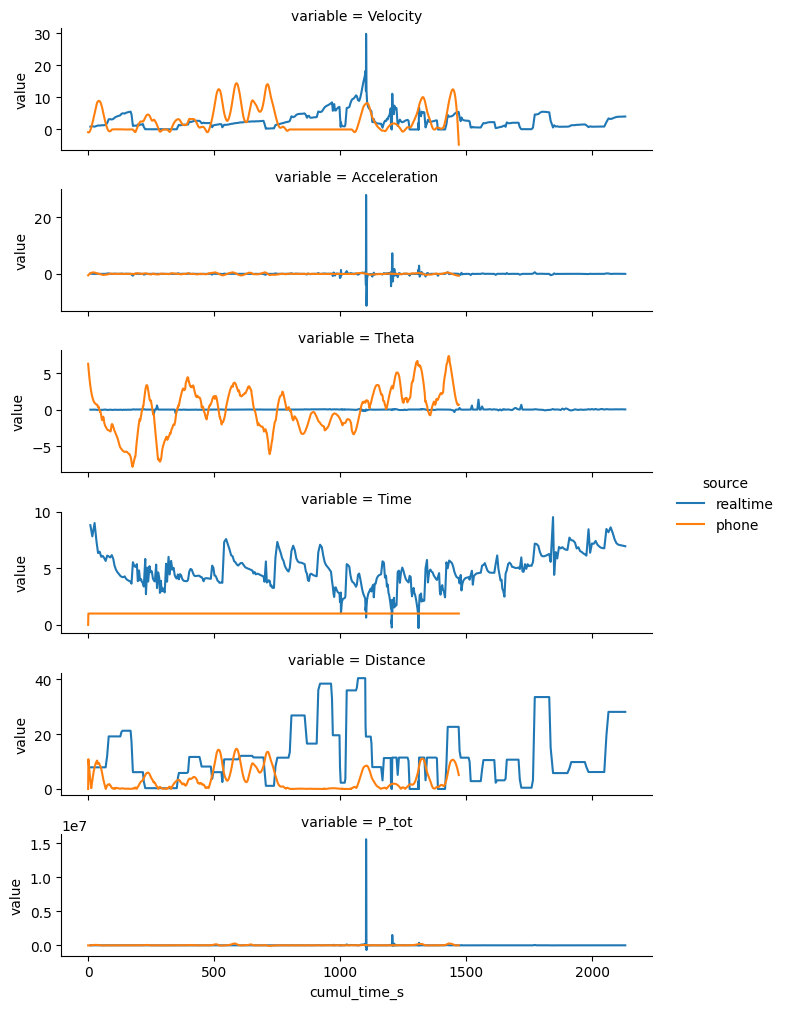

In [16]:
realtime_cycle_energy_df['source'] = 'realtime'
realtime_cycle_energy_df['cumul_time_s'] = realtime_cycle_energy_df['Time'].cumsum()
phone_cycle_energy_df['source'] = 'phone'
phone_cycle_energy_df['cumul_time_s'] = phone_cycle_energy_df['Time'].cumsum()
rt_df = realtime_cycle_energy_df[['source','cumul_time_s','Velocity','Acceleration','Theta','Time','Distance','P_tot']]
ph_df = phone_cycle_energy_df[['source','cumul_time_s','Velocity','Acceleration','Theta','Time','Distance','P_tot']]
plot_df = pd.concat([rt_df, ph_df], axis=0)
plotting.formatted_trajectory_lineplot(plot_df)

### Compare Phone Sensor Kinematics

In [ ]:
# fig, axes = plt.subplots(1,1,figsize=(8,4))
# phone_traj.gdf['calc_dist_m'].cumsum().plot(ax=axes)
# phone_traj.gdf['measured_speed_m_s'].cumsum().plot(ax=axes)
# phone_traj.gdf['measured_accel_m_s2'].cumsum().cumsum().plot(ax=axes)
# axes.legend(['gps','integrated speedometer','integrated accelerometer'])
# axes.set_title("Total Distance (m)")

In [ ]:
# fig, axes = plt.subplots(1,1,figsize=(8,4))
# phone_traj.gdf['calc_dist_m'].plot(ax=axes)
# phone_traj.gdf['measured_speed_m_s'].plot(ax=axes)
# phone_traj.gdf['measured_accel_m_s2'].cumsum().plot(ax=axes)
# axes.legend(['rate of change gps','speedometer','integrated accelerometer'])
# axes.set_title("Velocity (m/s)")

In [ ]:
# fig, axes = plt.subplots(1,1,figsize=(8,4))
# phone_traj.gdf['calc_dist_m'].diff().clip(-1,1).plot(ax=axes)
# phone_traj.gdf['measured_speed_m_s'].diff().plot(ax=axes)
# phone_traj.gdf['measured_accel_m_s2'].plot(ax=axes)
# axes.legend(['rate of change gps','rate of change speedometer','accelerometer'])
# axes.set_title("Acceleration (m/s^2)")

### Distance Along GTFS Shape

In [ ]:
# # GTFS shapes
# shape_lookup = standardfeeds.get_gtfs_shapes_lookup(f"../data/kcm_gtfs/{static_date}/")
# shapes = standardfeeds.get_gtfs_shapes(f"../data/kcm_gtfs/{static_date}/").to_crs("EPSG:32148")
# shapes.plot()

# route_ids = pd.unique(data_gtfs[(data_gtfs['route_short_name']==short_name) & (data_gtfs['direction_id']==0)].route_id)
# phone_shape = shapes[(shapes['route_id'].isin(route_ids)) & (shapes['direction_id']==0) & (shapes['service_id']==21133)]

# # Get one shape to work with
# sample_service_id, sample_route_id, sample_direction_id = data_gtfsrt.groupby(['service_id','route_id','direction_id']).count().index[0]
# print(sample_service_id, sample_route_id, sample_direction_id)

# # GTFS-RT
# sample_realtime = data_gtfsrt[(data_gtfsrt['service_id']==sample_service_id) & (data_gtfsrt['route_id']==sample_route_id) & (data_gtfsrt['direction_id']==sample_direction_id)].copy()

# # Shape
# sample_shape = shapes[(shapes['service_id']==sample_service_id) & (shapes['route_id']==sample_route_id) & (shapes['direction_id']==sample_direction_id)].copy()
# sample_shape.plot()

# # Get distance along shape
# sample_realtime['dist_along_line'] = sample_realtime['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))
# # sample_static['dist_along_line'] = sample_static['geometry'].apply(lambda pt: shapely.line_locate_point(sample_shape.geometry, pt))

# # Also get a timestamp column on the samples
# sample_realtime['t'] = pd.to_datetime(sample_realtime['locationtime'], unit='s')
# sample_realtime = sample_realtime.set_index('t')